In [1]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from torchvision.transforms import functional as F

from IPython.display import display, Markdown

from simple_relational_reasoning.embeddings.stimuli import build_differet_shapes_stimulus_generator, build_split_text_stimulus_generator, build_random_color_stimulus_generator
from simple_relational_reasoning.embeddings.triplets import QuinnTripletGenerator, ABOVE_BELOW_RELATION, BETWEEN_RELATION

In [2]:

FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight', should_print=False, should_prefix=True):
    if save_path is not None:
        save_path = os.path.abspath(save_path)
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX) and should_prefix:
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [3]:
reference_positions = [(105, 100)]

def plot_generator_examples(generator, ref_pos=reference_positions):
    plt.figure(figsize=(generator.n_target_types * 2.5, 3))

    for i in range(generator.n_target_types):
        x = generator.generate((80, 100 + (i * 20)), ref_pos, target_index=i)
        ax = plt.subplot(1, generator.n_target_types, i +1)
        ax.imshow(x.permute(1, 2, 0).numpy())


    plt.show()

def plot_triplets(triplets):
    n = triplets.shape[0]
    k = triplets.shape[1]

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(triplets[row, col].permute(1, 2, 0).numpy())

            if row == 0:
                if col == k - 1:
                    ax.set_title('Different Relation')
                elif col == k - 2:
                    ax.set_title('Same Relation')
                else:
                    ax.set_title(f'Habituation #{col + 1}')

    fig.tight_layout()

    plt.show()

FLIPS = (
    lambda x: x,
    F.hflip,
    F.vflip,
    lambda x: F.hflip(F.vflip(x))
)

FLIP_NAMES = ('None', 'Horizontal', 'Vertical', 'Both')


def plot_flipped_versions(base_images, base_image_names, save_path=None,
    flips=FLIPS, flip_names=FLIP_NAMES, text_kwargs=None):

    if text_kwargs is None:
        text_kwargs = {}
    
    k = len(base_images)
    n = len(flips)

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])

            ax.imshow(flips[row](base_images[col]).permute(1, 2, 0).numpy())

            if row == 0:
                ax.set_title(base_image_names[col], **text_kwargs)

            if col == 0:
                ax.set_ylabel(flip_names[row], **text_kwargs)

    fig.tight_layout()

    if save_path is not None:
        save_plot(save_path, should_prefix=False)

    plt.show()


GENERATOR_NAMES = ('color bar', 'split text', 'random colors')


def create_stimulus_generators_and_names(names=GENERATOR_NAMES, seed=None, **kwargs):
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))

    generators = (
        # build_differet_shapes_stimulus_generator(rng=rng, **kwargs), 
        
        build_split_text_stimulus_generator(
            # reference_box_size=10,
            # total_reference_size=(10, 140), n_reference_patches=8,
            # reference_patch_kwargs=dict(ylim=(-70, 70)),
            rng=rng, **kwargs),
        # build_random_color_stimulus_generator(rng=rng, **kwargs)
    )
    
    return zip(generators, names)

In [4]:
BASELINE_TRIPLET_KWARGS = dict(n_target_types=2, extra_diagonal_margin=0)
distance_endpoints_dict = {
    (False, False): (30, 80),
    (True, False): (50, 80),
    (True, True): (40, 80),  
}

# Stimulus conditions we have
* Above/below
    * With two reference objects
        * With or without a gap between them
* Between
* *The above two relations, but sideways (left/right and vertical between)* -- currently not plotted because it's just the regular stimuli transposed, but I can add that demo.
* Diagonal
* With both generators above



# Above/Below

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D2F77E50}


## color bar | above_below | one ref

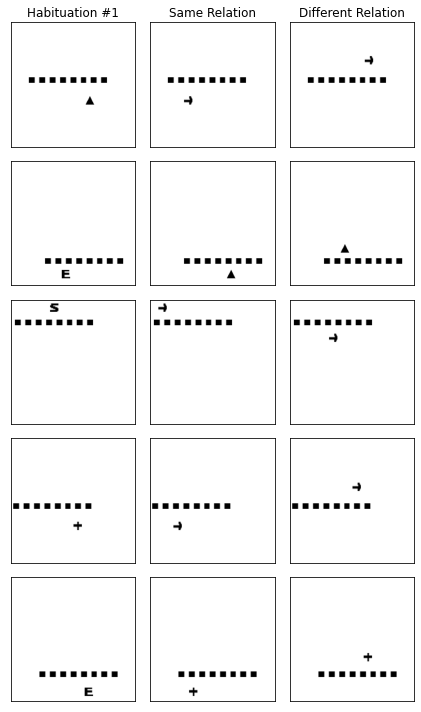

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A307C0}


## color bar | above_below | two refs | non-adjacent refs

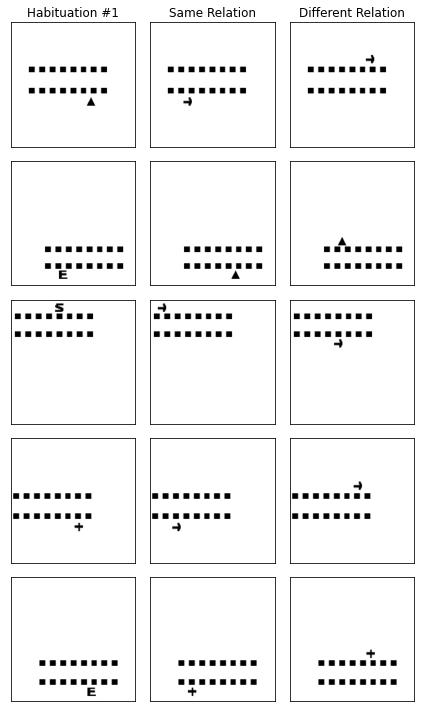

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A308B0}


## color bar | above_below | two refs | adjacent refs

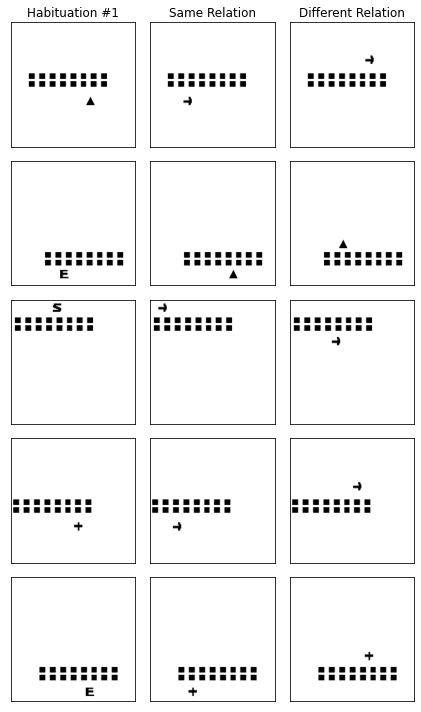

----

In [5]:
relation = ABOVE_BELOW_RELATION
N_examples = 5

display(Markdown('# Above/Below'))

for two_reference_objects in (False, True):
    for adjacent_reference_objects in (False, True):
        if not two_reference_objects and adjacent_reference_objects:
            continue

        distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

        for stimulus_generator, generator_name in create_stimulus_generators_and_names():
            
            triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
                relation=relation, two_reference_objects=two_reference_objects,
                adjacent_reference_objects=adjacent_reference_objects, **BASELINE_TRIPLET_KWARGS)

            adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
            title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
            display(Markdown(f'## {title}'))
            triplets = triplet_generator(N_examples, normalize=False)
            plot_triplets(triplets)
            display(Markdown('----'))


# Between/Outside

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A308B0}


## color bar | between

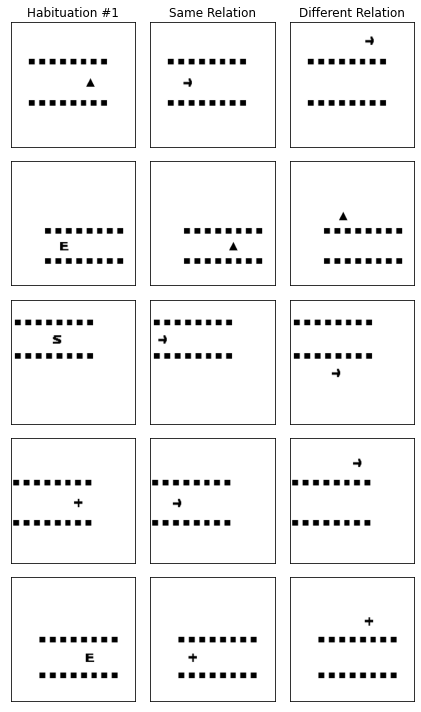

----

In [6]:
relation = BETWEEN_RELATION
distance_endpoints = (30, 80)
N_examples = 5

display(Markdown('# Between/Outside'))

distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

for stimulus_generator, generator_name in create_stimulus_generators_and_names():
    
    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=True,
        adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

    # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
    # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
    title = f'{generator_name} | {relation}'
    display(Markdown(f'## {title}'))
    triplets = triplet_generator(N_examples, normalize=False)
    plot_triplets(triplets)
    display(Markdown('----'))


# Diagonal Above/Below

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A308B0}


## color bar | above_below | 30 degrees

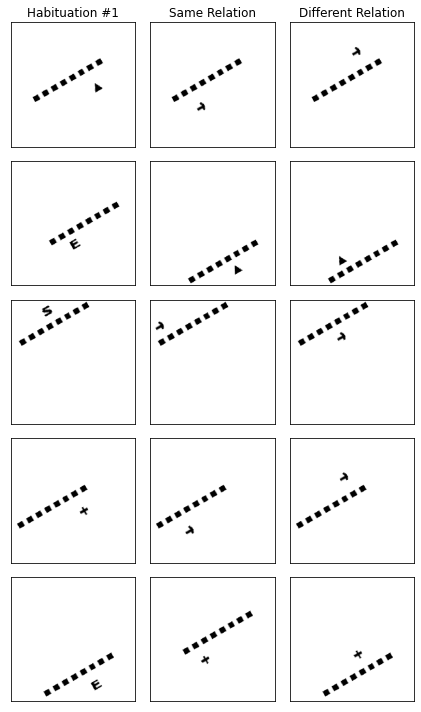

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A308B0}


## color bar | above_below | 45 degrees

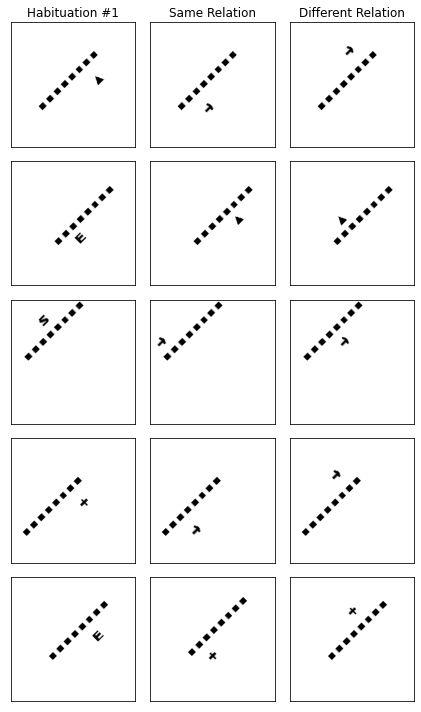

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A308B0}


## color bar | above_below | 60 degrees

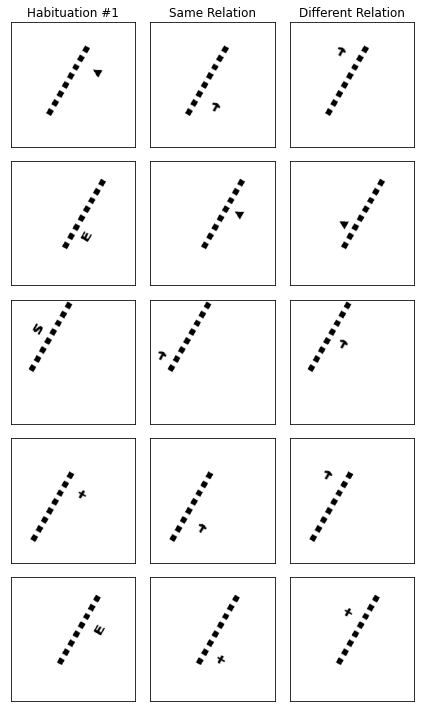

----

In [7]:
relation = ABOVE_BELOW_RELATION
distance_endpoints = (30, 80)
N_examples = 5

display(Markdown('# Diagonal Above/Below'))

# distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

for rotate_angle in (30, 45, 60):
    for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
        
        triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
            relation=relation, two_reference_objects=False,
            adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

        # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
        # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
        title = f'{generator_name} | {relation} | {rotate_angle} degrees'
        display(Markdown(f'## {title}'))
        triplets = triplet_generator(N_examples, normalize=False)
        plot_triplets(triplets)
        display(Markdown('----'))


Note for the above: we could obviously run all of the different variations of above/below (two reference objects, what sort of gap betwen them, etc.) on the diagonal case as well, if we wanted to.

Similarly, we could run between/outside diagonally, too.

Not plotted but also exist are the left/right and vertical between stimuli, which are just the non-diagonal stimuli transposed. 

Let me know if you want me to plot any of the above.

### TODO:
One significant things is still missing here:
1. I haven't finished implementing the condition where we create more than one habituation stimulus.

# Multiple Habituation Stimuli

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A308B0}


## 4 habituation stimuli

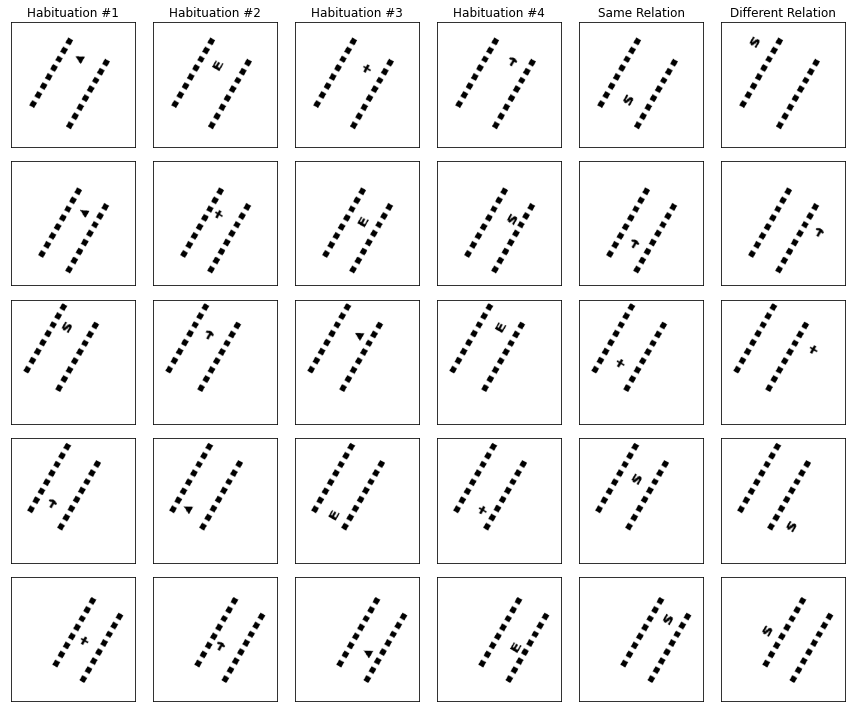

----

In [8]:
relation = BETWEEN_RELATION
distance_endpoints = (40, 80)
N_examples = 5
n_habituation_stimuli = 4

display(Markdown('# Multiple Habituation Stimuli'))

rng = np.random.default_rng(n_habituation_stimuli)
stimulus_generator = build_split_text_stimulus_generator(rng=rng, rotate_angle=60)
# stimulus_generator = build_random_color_stimulus_generator(rng=rng)

triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
    relation=relation, two_reference_objects=True, 
    adjacent_reference_objects=False, n_habituation_stimuli=n_habituation_stimuli,
    **BASELINE_TRIPLET_KWARGS)

# adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
# title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
title = f'{n_habituation_stimuli} habituation stimuli'
display(Markdown(f'## {title}'))
triplets = triplet_generator(N_examples, normalize=False)
plot_triplets(triplets)
display(Markdown('----'))


## Flipping Manipulation -- Above/Below

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A30A90}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D2F775E0}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A30A90}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D2F775E0}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5C1F535E0}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D2F775E0}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5C1F538B0}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5C1F539A0}


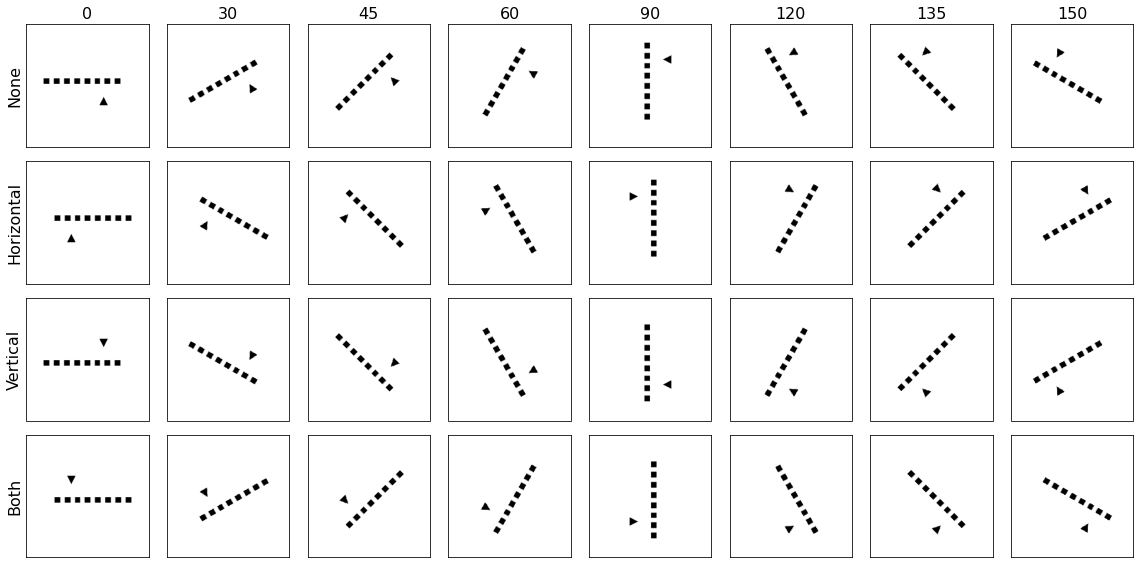

In [9]:

relation = ABOVE_BELOW_RELATION
distance_endpoints = (30, 80)
N_examples = 1

display(Markdown('## Flipping Manipulation -- Above/Below'))

images = []

for rotate_angle in [0, 30, 45, 60, 90, 120, 135, 150]:
    for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
    
        triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
            relation=relation, two_reference_objects=False, transpose=False,
            adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

        triplets = triplet_generator(N_examples, normalize=False)
        images.append(triplets[0][0])



plot_flipped_versions(images, [0, 30, 45, 60, 90, 120, 135, 150],
    save_path='/Users/guydavidson/Downloads/flipping_above_below.png',
    text_kwargs=dict(fontsize=16))

## Flipping Manipulation -- Between

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5C1F53220}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A30310}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A309A0}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A30B80}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A307C0}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A30C70}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A30D60}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A30E50}


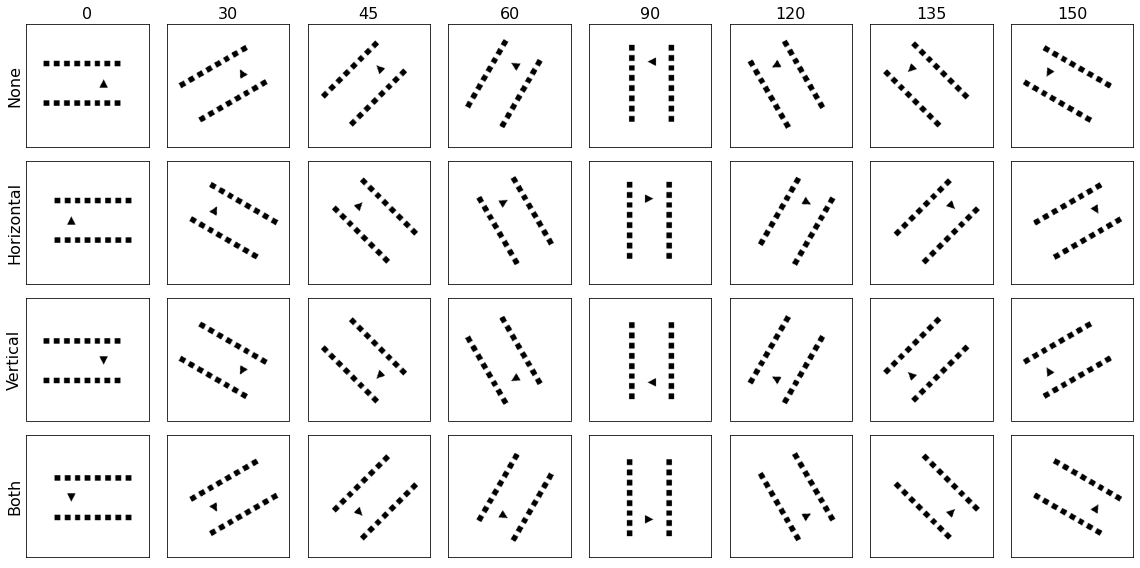

In [10]:

relation = BETWEEN_RELATION
distance_endpoints = (30, 80)
N_examples = 1
TRIPLET_INDEX = 0

display(Markdown('## Flipping Manipulation -- Between'))

images = []

for rotate_angle in [0, 30, 45, 60, 90, 120, 135, 150]:
    for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
    
        triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
            relation=relation, two_reference_objects=True, transpose=False,
            adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

        triplets = triplet_generator(N_examples, normalize=False)
        images.append(triplets[0][TRIPLET_INDEX])



plot_flipped_versions(images, [0, 30, 45, 60, 90, 120, 135, 150],
    save_path='/Users/guydavidson/Downloads/flipping_between.png',
    text_kwargs=dict(fontsize=16))

## Flipping Manipulation -- Between

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A30D60}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A30E50}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A30D60}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5C1F534F0}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A30D60}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A30D60}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5C1F537C0}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FF5D1A30D60}


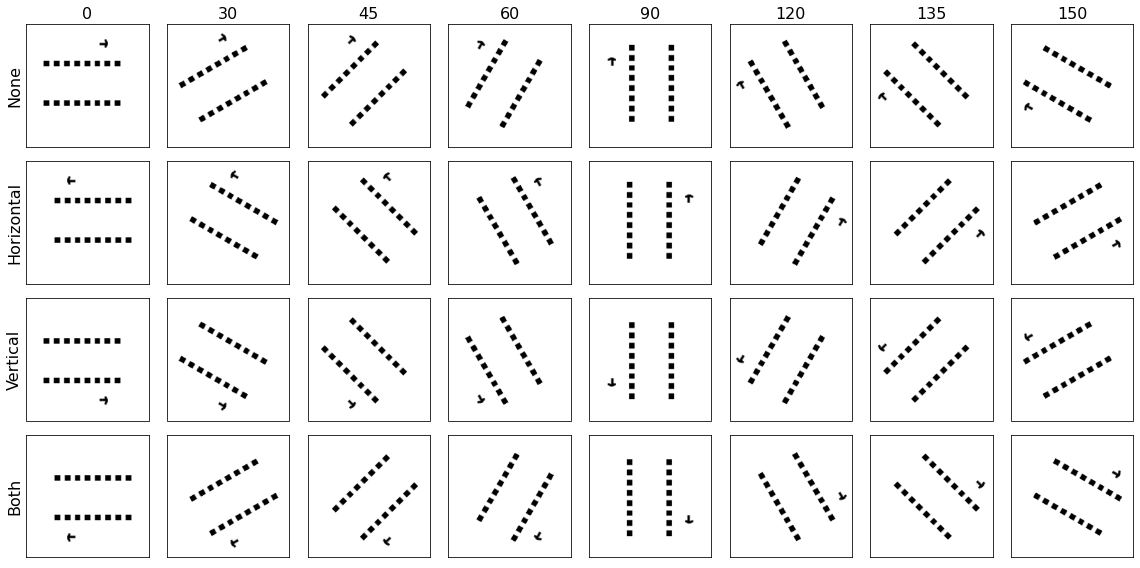

In [11]:

relation = BETWEEN_RELATION
distance_endpoints = (30, 80)
N_examples = 1
TRIPLET_INDEX = 2

display(Markdown('## Flipping Manipulation -- Between'))

images = []

for rotate_angle in [0, 30, 45, 60, 90, 120, 135, 150]:
    for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
    
        triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
            relation=relation, two_reference_objects=True, transpose=False,
            adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

        triplets = triplet_generator(N_examples, normalize=False)
        images.append(triplets[0][TRIPLET_INDEX])



plot_flipped_versions(images, [0, 30, 45, 60, 90, 120, 135, 150],
    save_path='/Users/guydavidson/Downloads/flipping_outside.png',
    text_kwargs=dict(fontsize=16))